# Visualization Notebook

This is essentially a diffusion problem, and the partial differential equation that drives this phenomenon for a 2D problem is:

$$ Lap(T) = 0$$
$$or$$
$$\frac{\partial^2T}{\partial x^2} + \frac{\partial^2T}{\partial y^2} = 0$$ 

#### Imports

In [1]:
import torch.autograd as autograd

import matplotlib as mlp
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns

import numpy as np
import pandas as pd

import time

In [3]:
from FCN import FCN
from tools import *

In [4]:
%matplotlib inline

#### Function tools

In [5]:
def partial_diff_equation(f, g):
    f_x_y = autograd.grad(f,g,torch.ones([g.shape[0], 1]), retain_graph=True, create_graph=True)[0] #first derivative
    f_xx_yy = autograd.grad(f_x_y,g,torch.ones(g.shape), create_graph=True)[0]#second derivative

    f_yy = f_xx_yy[:,[1]] # we select the 2nd element for y (the first one is x) (Remember the input X=[x,y]) 
    f_xx = f_xx_yy[:,[0]] # we select the 1st element for x (the second one is y) (Remember the input X=[x,y])

    u = f_xx + f_yy # loss equation
    u = u.float()

    return u

In [6]:
def pplot(u_pred,lossTensor, num_ticks = 11, isolines = True, mask = np.full((1500, 1500), False)):
    plt.close()
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12,6))
    fig.tight_layout(pad = 5)

    num_ticks = 11
    # number of points in x and y
    nx = u_pred.shape[0]
    x = np.linspace(0, 1, nx)
    y = np.linspace(0, 1, nx)
    
    # the index of the position of yticks
    yticks = np.linspace(0, len(y) - 1, num_ticks, dtype=int)
    xticks = np.linspace(0, len(x) - 1, num_ticks, dtype=int)

    fmt = lambda x, pos: '{:.2f}'.format(x/nx, pos)

    if isolines:
        plt.subplot(1,2,1)

        m = min([min(row) for row in u_pred])
        M = max([max(row) for row in u_pred])

        levels = np.arange(m, M, (1 / float(num_ticks)) * (M - m))
        CS = plt.contour(u_pred, colors="white", levels=levels)
        plt.clabel(CS, inline = 1, fontsize = 10)
    
    sns.heatmap(u_pred, 
                ax = ax1, 
                cmap = "rocket_r",
                cbar_kws={'label': r'$T^*$', 'shrink': 0.8},
                square = True,
                mask = mask)
    
    
    ax1.invert_yaxis()
    ax1.set_xticks(xticks)
    ax1.set_yticks(yticks)

    ax1.xaxis.set_major_formatter(mlp.ticker.FuncFormatter(fmt))
    ax1.yaxis.set_major_formatter(mlp.ticker.FuncFormatter(fmt))
    ax1.set(xlabel = r'$x^*$', ylabel = r'$y^*$')
    ax1.set_title('Temperature')

    minLoss = np.percentile(lossTensor, 5)
    maxLoss = np.percentile(lossTensor, 95)

    # rounds up value to the next multiple of 0.05
    value = ((max(abs(minLoss), abs(maxLoss)) + 0.049)//(0.05))*0.05

    plt.subplot(1,2,2)
    
    sns.heatmap(lossTensor,
                ax = ax2,
                vmin = -value,
                vmax = value,
                cmap = "vlag_r",
                cbar_kws={'label': r'$Loss$', 'shrink': 0.8},
                square = True,
                mask = mask)
    
    ax2.invert_yaxis()
    ax2.set_xticks(xticks)
    ax2.set_yticks(yticks)

    ax2.xaxis.set_major_formatter(mlp.ticker.FuncFormatter(fmt))
    ax2.yaxis.set_major_formatter(mlp.ticker.FuncFormatter(fmt))
    ax2.set(xlabel = r'$x^*$', ylabel = r'$y^*$')
    ax2.set_title('Loss')

    plt.show()

In [7]:
def pplot2(u_pred, lossTensor, X_train_PDE, X_train, loss_array, num_ticks = 11, isolines = True, mask = np.full((1500, 1500), False)):
    plt.close()
    fig, axs = plt.subplots(2, 2, figsize = (12,12))
    fig.tight_layout(pad = 5)

    # number of points in x and y
    nx = u_pred.shape[0]
    x = np.linspace(0, 1, nx)
    y = np.linspace(0, 1, nx)

    # the index of the position of yticks
    yticks = np.linspace(0, len(y) - 1, num_ticks, dtype=int)
    xticks = np.linspace(0, len(x) - 1, num_ticks, dtype=int)

    fmt = lambda x, pos: '{:.2f}'.format(x/nx, pos)

    if isolines:
        plt.subplot(2,2,1)

        m = min([min(row) for row in u_pred])
        M = max([max(row) for row in u_pred])

        levels = np.arange(m, M, (1 / float(num_ticks)) * (M - m))
        CS = plt.contour(u_pred, colors="white", levels=levels)
        plt.clabel(CS, inline = 1, fontsize = 10)

    sns.heatmap(u_pred, 
                ax = axs[0, 0], 
                cmap = "rocket_r",
                cbar_kws={'label': r'$T^*$', 'shrink': 0.8},
                square = True,
                mask = mask)
    
    axs[0, 0].invert_yaxis()
    axs[0, 0].set_xticks(xticks)
    axs[0, 0].set_yticks(yticks)

    axs[0, 0].xaxis.set_major_formatter(mlp.ticker.FuncFormatter(fmt))
    axs[0, 0].yaxis.set_major_formatter(mlp.ticker.FuncFormatter(fmt))
    axs[0, 0].set(xlabel = r'$x^*$', ylabel = r'$y^*$')
    axs[0, 0].set_title('Temperature')

    minLoss = np.percentile(lossTensor, 5)
    maxLoss = np.percentile(lossTensor, 95)

    # rounds up value to the next multiple of 0.05
    value = ((max(abs(minLoss), abs(maxLoss)) + 0.049)//(0.05))*0.05


    sns.heatmap(lossTensor,
                ax = axs[0, 1],
                vmin = -value,
                vmax = value,
                cmap = "vlag_r",
                cbar_kws={'label': r'$Loss$', 'shrink': 0.8},
                square = True,
                mask = mask)
    
    axs[0, 1].invert_yaxis()
    axs[0, 1].set_xticks(xticks)
    axs[0, 1].set_yticks(yticks)

    axs[0, 1].xaxis.set_major_formatter(mlp.ticker.FuncFormatter(fmt))
    axs[0, 1].yaxis.set_major_formatter(mlp.ticker.FuncFormatter(fmt))
    axs[0, 1].set(xlabel = r'$x^*$', ylabel = r'$y^*$')
    axs[0, 1].set_title('Loss')

    legend_handles = []


    sns.scatterplot(X_train_PDE, 
                    x = X_train_PDE[:, 0], 
                    y = X_train_PDE[:, 1], 
                    ax = axs[1, 0],
                    marker = ".",
                    color = 'deepskyblue', 
                    legend = False)
    sns.scatterplot(X_train, 
                    x = X_train[:, 0], 
                    y = X_train[:, 1], 
                    ax = axs[1, 0],
                    marker = "o",  
                    color = 'coral',
                    legend = False)
                    
    legend_handles = [
        mlines.Line2D([], [], color= 'deepskyblue', marker= '.',linestyle='None', label= 'PDE Sampling Points'),
        mlines.Line2D([], [], color= 'coral', marker= 'o',linestyle='None', label='BC Sampling Points')
    ]

    axs[1, 0].set(xlabel = r'$x^*$', ylabel = r'$y^*$')
    axs[1, 0].set_title('Sampling points for Neural Network')
    axs[1, 0].legend(handles = legend_handles, loc = 1)

    loss_array_names = ['Combined Loss', 'BC Loss', 'PDE Loss']
    loss_array_style = ['green', 'blue', 'orange']

    df = pd.DataFrame(np.transpose(loss_array), columns = ['BC Loss', 'PDE Loss', 'Combined Loss'], dtype = float)

    sns.lineplot(df,
                ax = axs[1, 1],
                linestyle = 'solid',
                marker = ','
                )
    
    # for i in range(3):
    #     sns.lineplot(
    #         loss_array[i],
    #         palette = loss_array_style[i],
    #         ax = axs[1, 1]
    #     )

    axs[1, 1].set(xlabel = r'$Iteration$', ylabel = r'$Loss$', yscale = 'log')
    axs[1, 1].legend(loc = 1)
    axs[1, 1].set_title('Loss')

    plt.show()

In [8]:
class Viz_Case():
    def __init__(self, suffix, Problem):
        self.Problem = Problem

        X_train_PDE, X_train_Nu, T_train_Nu, X_test = self.Problem.getDomains()

        X_train, T_train = self.Problem.X_train, self.Problem.T_train

        x = self.Problem.X[:,0]
        y = self.Problem.Y[0,:]

        N_x, N_y = self.Problem.N_x, self.Problem.N_y

        self.suffix = suffix

        PINN = FCN(self.Problem, X_train_PDE, X_train, T_train, X_test, partial_diff_equation)
        PINN.load_state_dict(torch.load('./PINN_files/PINN_' + suffix + '.pt'))

        u_pred = PINN.forward(X_test)
        self.u_pred = np.transpose(np.reshape(u_pred.detach().numpy(), (N_x, N_y)))

        lossTensor = PINN.lossTensor(X_test)
        self.lossTensor = np.reshape(lossTensor.detach().numpy(), (N_x,N_y))

        if Problem.squareHasHole:
            self.mask = self.Problem.isNotInCircleTensorOrder2(self.u_pred, x, y)
        else:
            self.mask = np.full((N_x, N_y), True)

        arr_bc = np.loadtxt('./history_files/loss_bc_history_' + self.suffix + '.csv', delimiter= ",", dtype= float)
        arr_pde = np.loadtxt('./history_files/loss_pde_history_' + self.suffix + '.csv', delimiter= ",", dtype= float)
        arr_total = np.loadtxt('./history_files/loss_history_' + self.suffix + '.csv', delimiter= ",", dtype= float)

        self.loss_array = [arr_bc, arr_pde, arr_total]

    def setProblem(self):
        self.Problem = Problem

    def plot1(self, isolines = True):
        pplot(self.u_pred, self.lossTensor,isolines = isolines, mask = (1 - self.mask))

    def plot2(self, isolines = True):
        X_train_PDE, X_train = self.Problem.getDomains()[:2]
        pplot2(self.u_pred, self.lossTensor, X_train_PDE, X_train, self.loss_array,isolines = isolines, mask = (1 - self.mask))

#### Setup

In [9]:
dirichletProblem = Problem(partial_diff_equation, squareHasHole = True)
dirichletProblem.BCbooleans(BC_left = True, BC_top = True, BC_right = True, BC_bottom = True)
dirichletProblem.setTemp(T_left = 0, T_top = 0, T_right= 0, T_bottom= 0, T_circle= 1)

In [10]:
X_train_PDE, X_train_Nu, T_train_Nu, X_test = dirichletProblem.getDomains()

X_train, T_train = dirichletProblem.X_train, dirichletProblem.T_train

x = dirichletProblem.X[:,0]
y = dirichletProblem.Y[0,:]

N_x, N_y = dirichletProblem.N_x, dirichletProblem.N_y

/Users/thyagoc/miniforge3/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [14]:
u_pred_list = []
lossTensor_list = []

for i in range(16):
    suffix = 'dirichlet_' + str(i)

    PINN = FCN(dirichletProblem, X_train_PDE, X_train, T_train, X_test, partial_diff_equation)
    PINN.load_state_dict(torch.load('./sampling_points_study/PINN_' + suffix + '.pt'))

    u_pred = PINN.forward(X_test)
    u_pred = np.transpose(np.reshape(u_pred.detach().numpy(), (N_x, N_y)))
    u_pred_list.append(u_pred)

    lossTensor = PINN.lossTensor(X_test)
    lossTensor = np.reshape(lossTensor.detach().numpy(), (N_x,N_y))
    lossTensor_list.append(lossTensor)

    mask = np.full((N_x, N_y), True)

    print('[' + (i + 1)*'=' + (15 - i)*' ' + '] \t' + str((i + 1)*100/16) + '% Done')

[=               ] 	6.25% Done
[==              ] 	12.5% Done
[===             ] 	18.75% Done
[====            ] 	25.0% Done
[=====           ] 	31.25% Done
[======          ] 	37.5% Done
[=======         ] 	43.75% Done
[========        ] 	50.0% Done
[=========       ] 	56.25% Done
[==========      ] 	62.5% Done
[===========     ] 	68.75% Done
[============    ] 	75.0% Done
[=============   ] 	81.25% Done
[==============  ] 	87.5% Done
[=============== ] 	93.75% Done
[================] 	100.0% Done


In [21]:
lossTensor = np.loadtxt('./iter_evolution_study/lossTensor/lossTensor@' + str((i + 1)*100) + '.csv', delimiter= ",", dtype= float)

In [25]:
lossTensor

array([[-0.00336859, -0.00335166, -0.00333475, ...,  0.00129903,
         0.00129472,  0.00129033],
       [-0.0033578 , -0.00334087, -0.00332399, ...,  0.00129628,
         0.00129184,  0.00128743],
       [-0.00334704, -0.00333013, -0.00331326, ...,  0.00129348,
         0.00128895,  0.00128458],
       ...,
       [ 0.00141862,  0.00141175,  0.00140482, ..., -0.00037834,
        -0.00037862, -0.00037896],
       [ 0.00141588,  0.00140897,  0.00140208, ..., -0.00038231,
        -0.00038257, -0.0003829 ],
       [ 0.00141294,  0.0014062 ,  0.00139917, ..., -0.00038618,
        -0.00038661, -0.00038686]])

[=              ] 	 6.67 % Done
[==             ] 	 13.33 % Done
[===            ] 	 20.00 % Done
[====           ] 	 26.67 % Done
[=====          ] 	 33.33 % Done
[======         ] 	 40.00 % Done
[=======        ] 	 46.67 % Done
[========       ] 	 53.33 % Done
[=========      ] 	 60.00 % Done
[==========     ] 	 66.67 % Done
[===========    ] 	 73.33 % Done
[============   ] 	 80.00 % Done
[=============  ] 	 86.67 % Done
[============== ] 	 93.33 % Done
[===============] 	 100.00 % Done


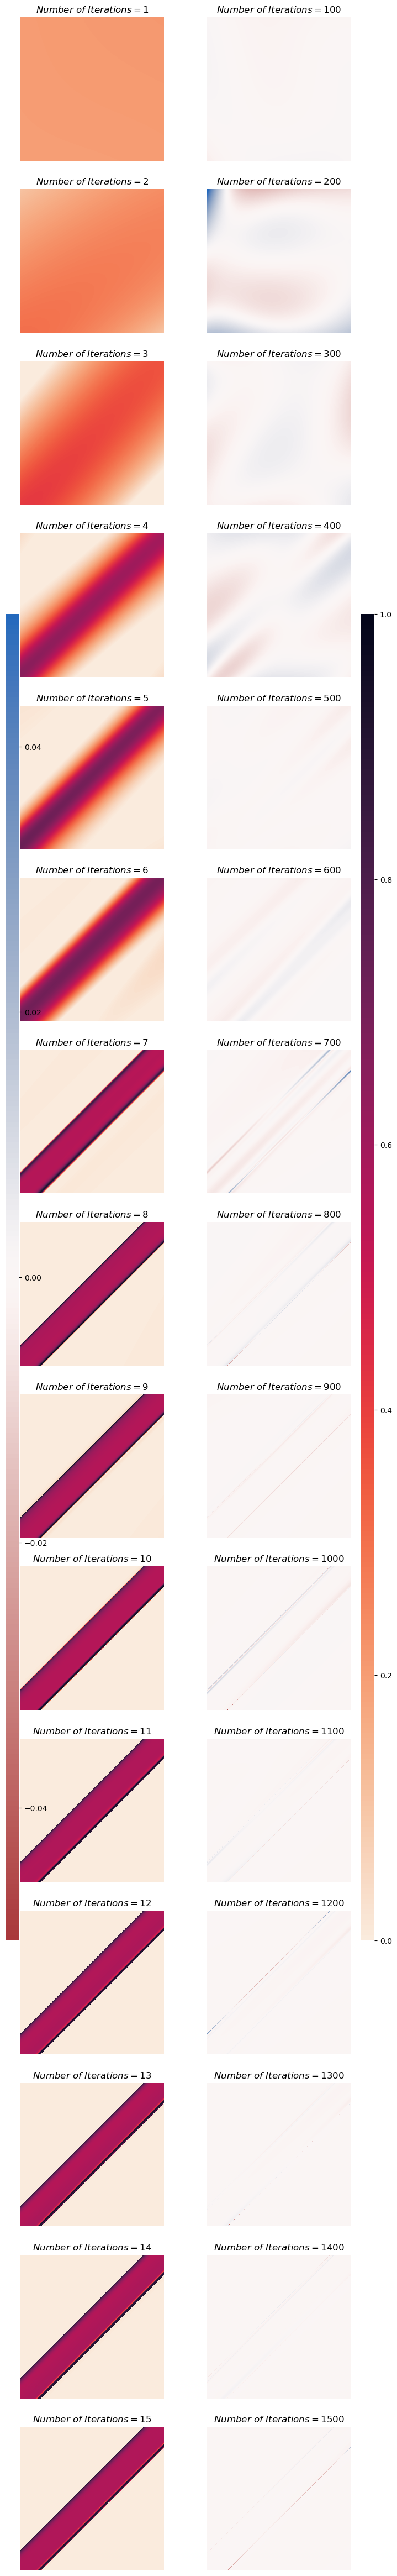

In [32]:
num_ticks = 11

fig, axs = plt.subplots(15, 2, figsize = (8, 60))

cbar_ax_u = fig.add_axes([.91, .3, .03, .4])
cbar_ax_loss = fig.add_axes([.105, .3, .03, .4])



for i in range(15):
    u_pred = np.loadtxt('./iter_evolution_study/u_pred/u_pred@' + str((i + 1)*100) + '.csv', delimiter= ",", dtype= float)
    lossTensor = np.loadtxt('./iter_evolution_study/lossTensor/lossTensor@' + str((i + 1)*100) + '.csv', delimiter= ",", dtype= float)
    lossTensor = np.reshape(lossTensor, (N_x, N_y))
    

    sns.heatmap(u_pred, 
                ax = axs[i, 0], 
                cmap = "rocket_r",
                square = True,
                cbar_ax= cbar_ax_u,
                vmin = 0,
                vmax = 1)
    
    axs[i, 0].invert_yaxis()
    axs[i, 0].axis('off')

    axs[i, 0].set_title(r'$ Number \ of \ Iterations = $' + str((i + 1)))

    sns.heatmap(lossTensor, 
                ax = axs[i, 1], 
                cmap = "vlag_r",
                square = True,
                cbar_ax= cbar_ax_loss,
                vmin = -0.05,
                vmax = 0.05)
    
    axs[i, 1].invert_yaxis()
    axs[i, 1].axis('off')

    axs[i, 1].set_title(r'$ Number \ of \ Iterations = $' + str((i + 1)*100))

    time.sleep(5)

    print('[' + (i + 1)*'=' + (14 - i)*' ' + '] \t ' + '{:.2f}'.format((i + 1)*100/15) + ' % Done')
    
plt.show()